In [1]:
%matplotlib inline

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [3]:
g5nr7km_dataset=xr.open_dataset('http://weather.rsmas.miami.edu/repository/opendap/synth:1142722f-a386-4c17-a4f6-0f685cd19ae3:L0c1TlIvR0VPUzUtTmF0dXJlLVJ1bi1JbnN0MzBtaW4tN2ttX3ByZXNzdXJlX21ldGhvZDIubmNtbA==/entry.das')

In [4]:
g5nr7km_dataset

<xarray.Dataset>
Dimensions:  (lat: 2881, lev: 72, lon: 5760, time: 36576)
Coordinates:
  * time     (time) datetime64[ns] 2005-05-15T21:30:00 2005-05-15T22:00:00 ...
  * lev      (lev) float64 0.01 0.02 0.0327 0.0476 0.066 0.0893 0.1197 ...
  * lat      (lat) float64 -90.0 -89.94 -89.88 -89.81 -89.75 -89.69 -89.62 ...
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.8 -179.8 -179.7 -179.6 ...
Data variables:
    cloud    (time, lev, lat, lon) float64 ...
    qi       (time, lev, lat, lon) float64 ...
    ql       (time, lev, lat, lon) float64 ...
    qr       (time, lev, lat, lon) float64 ...
    qs       (time, lev, lat, lon) float64 ...
    qv       (time, lev, lat, lon) float64 ...
    taucli   (time, lev, lat, lon) float64 ...
    tauclw   (time, lev, lat, lon) float64 ...
    tauir    (time, lev, lat, lon) float64 ...
    t        (time, lev, lat, lon) float64 ...
    u        (time, lev, lat, lon) float64 ...
    v        (time, lev, lat, lon) float64 ...
    w        (time,

## make a slice of data for required time and lat, lon bounds
check times by printing g5nr7km_dataset.time

In [5]:
sample_data=g5nr7km_dataset.sel(time='2005-05-15T21:30:00.000000000') # can use .isel(time=slice(startindex:endindex)) 
                                                                      # for selecting multiple times
sample_data=sample_data.sel(lat=slice(0,4),lon=slice(60,64))

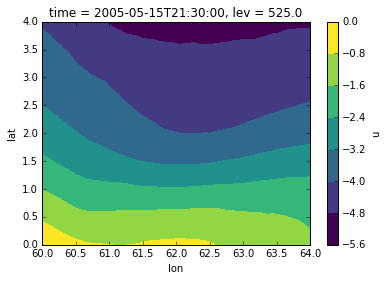

In [6]:
sample_data['u'][50,:,:].plot.contourf() #check plot at a level index 50 also could use .sel(level=some hpa)

## Define convinient functions for regridding and subgrid scale fluxes
Both functions take nlon and nlat values for global grid but return values only at the sampled grid


Note that levels are also taken care of internally

In [7]:
def regrid(variable,nlon,nlat):
    assert isinstance(variable,xr.DataArray),"please pass a xarray DataArray not whole dataset"
    lat_gpd=variable.groupby_bins('lat',np.arange(-90,91,float(180.0)/nlat))
    latreg=lat_gpd.mean(dim='lat')
    lon_gpd=latreg.groupby_bins('lon',np.arange(-180,180,float(180.0)/nlon))
    regrided=lon_gpd.mean(dim='lon')
    regrided=regrided.rename({'lat_bins':'lat','lon_bins':'lon'})
    lats=[]
    for latbin in regrided.lat.values:
        latbounds=[float(lat) for lat in str(latbin).strip(r'(])').split(',')]
        lats.append(np.mean(latbounds))
    lons=[]
    for lonbin in regrided.lon.values:
        lonbounds=[float(lon) for lon in str(lonbin).strip(r'(])').split(',')]
        lons.append(np.mean(lonbounds))
    regrided['lon']=lons
    regrided['lat']=lats
    return regrided

In [8]:
def subgrid(variable,nlon,nlat):
    assert isinstance(variable,xr.DataArray),"please pass a xarray DataArray not whole dataset"
    lat_gpd=variable.groupby_bins('lat',np.arange(-90,91,float(180.0)/nlat))
    latreg=lat_gpd.apply(lambda x:x-x.mean(dim='lat'))
    lon_gpd=latreg.groupby_bins('lon',np.arange(-180,180,float(180.0)/nlon))
    subgrided=lon_gpd.apply(lambda x:x-x.mean(dim='lon'))
    return subgrided

In [9]:
ureg=regrid(sample_data['u'],90,45)

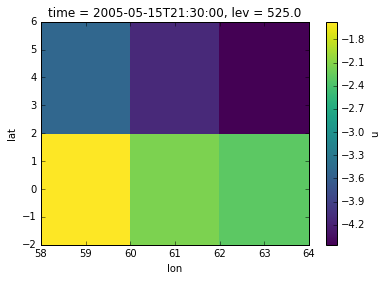

In [10]:
ureg[50,:,:].plot.pcolormesh()

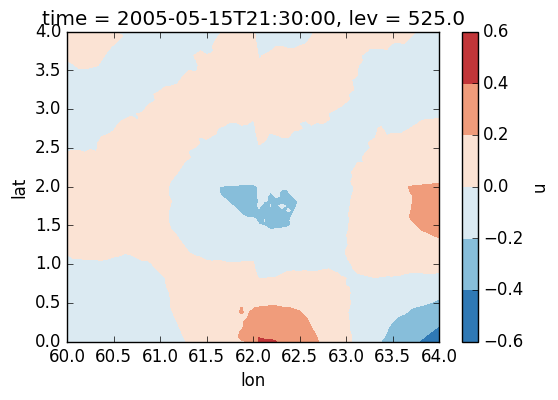

In [11]:
usubgrid=subgrid(sample_data['u'],90,45)
usubgrid[50,:,:].plot.contourf()

## Plotting vertical cross-sections
use functions .sel(lat=val) or .sel(lon=val) for transect along a lat or lon

use functions .sel_points(method='nearest',lat=latlist,lon=lonlist) for any other transects

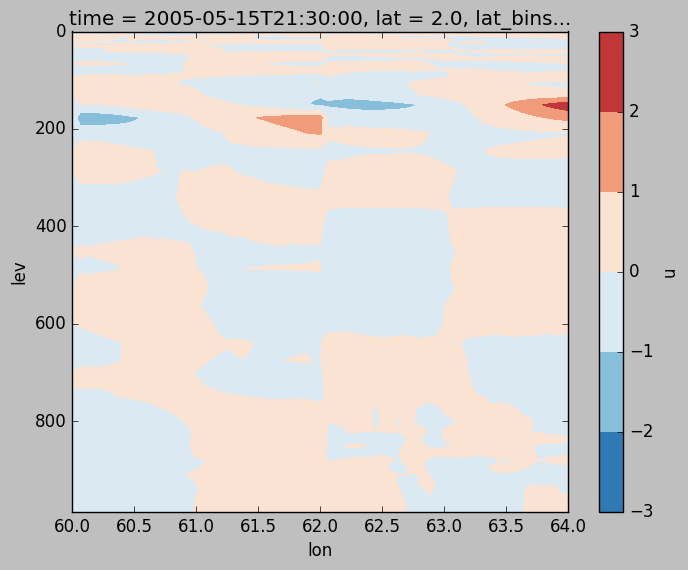

In [12]:
usubgrid.sel(lat=2).plot.contourf(yincrease=False)

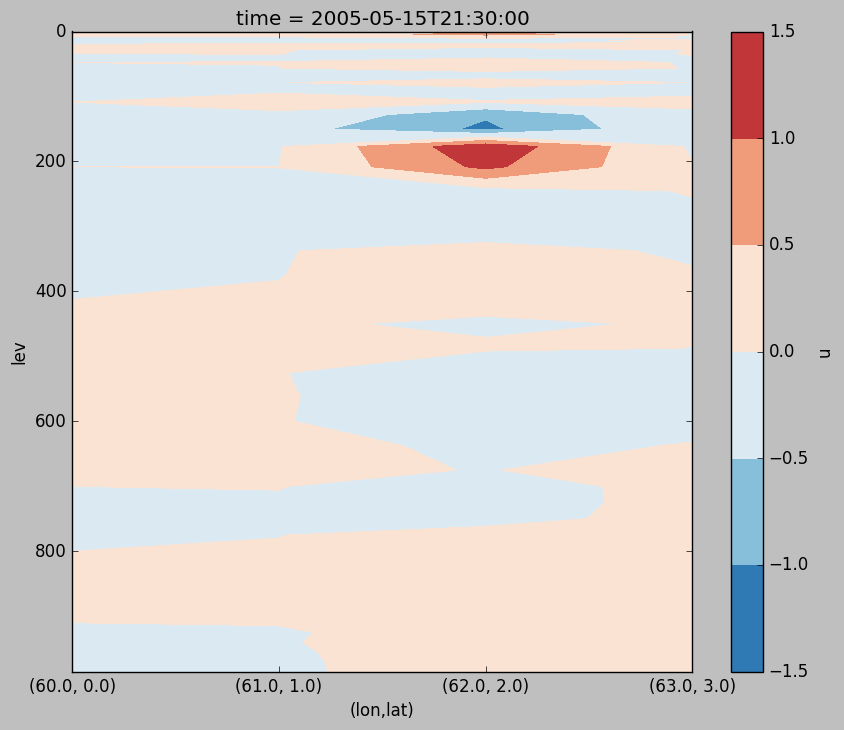

In [15]:
s=usubgrid.sel_points(method='nearest',lat=range(0,4),lon=range(60,64))
f,ax=plt.subplots(1,1)
f.set_size_inches(10,8)
s.plot.contourf(x='points',y='lev',yincrease=False,ax=ax)
lonlattics=[repr((lon,lat))for lat,lon in zip(s.lat.values,s.lon.values)]
plt.xticks(s.points,lonlattics)
plt.xlabel('(lon,lat)')